LSTMを定義してみる  


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [24]:
class LSTM(nn.Module):
    def __init__(
            self, 
            input_size, 
            hidden_size, 
            output_size, 
            num_layers, 
            bias=True, 
            bidirectional = False,
            dropout=0.0):
        
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1 # 双方向か否かでlstmの出力数が変わるみたいなので

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bias=bias,batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
    
    def forward(self, x):
        # 初期隠れ状態とセル状態をゼロで初期化 こうしないと隠れ状態が残ったままになる
        h0 = torch.zeros(self.num_layers*self.num_directions, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers*self.num_directions, x.size(0), self.hidden_size, device=x.device)

        # LSTM層
        # 入力xと文脈h0,c0 out(batch_size, 500, hidden_size*num_directions)
        out, _ = self.lstm(x, (h0, c0)) 

        # 全結合層
        """# out(batch_size, 500, hidden_size*num_directions)
        out = out.contiguous().view(-1, self.hidden_size * self.num_directions)
        # out(batch_size*500, hidden_size*self.num_directions)
        out = self.fc(out)# outには８クラス分類のやつが入る
        # out(batch_size*500, 8)

        # x.shapeは(batch_size, 500, 9)だったっけ？
        out = out.view(x.size(0), x.size(1), 8)
        # out(batch_size, 500, 8)
    
        # シーケンス全体の平均を取って最終出力にする
        out = torch.mean(out, dim=1)"""
        out = out[:,-1,:]
        out = self.fc(out)
        # out(batch_size, 8)
        return out

In [3]:
# X:説明変数 y:目的ラベル
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    X = torch.tensor(X, dtype=torch.float32)
    if y is not None:
        y = torch.tensor(y-1, dtype=torch.long)
        dataset = TensorDataset(X,y)
    else:
        dataset = TensorDataset(X)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def forward_by_batches(model, dataloader):
    Y = []
    model.eval()
    with torch.no_grad():
        for x in dataloader:
            x = x[0].to(device)
            Y.append(model(x))
    model.train()

    Y = torch.cat(Y) # Yをテンソルに変換
    return Y


def evaluate_model(model, X, Y, batch_size=1024):
    dataloader = create_dataloader(X, Y, batch_size=batch_size, shuffle=False)
    Y_pred = forward_by_batches(model, dataloader)
    loss = F.cross_entropy(Y_pred, torch.tensor(Y-1.0, dtype=torch.long).to(device)).item() # クロスエントロピー損失の計算 仕方なく0~7クラス分類とする

    Y_pred = F.softmax(Y_pred, dim=1) 
    Y_pred = torch.argmax(Y_pred, dim=1)  # 最も高い確率のY_predのラベルを予測ラベルとしてY_predに入れられる。
    Y_pred = Y_pred + 1  # 予測ラベルに1を加えて1~8の範囲に変換する
    Y_pred = Y_pred.cpu().numpy()  # テンソルでGPUにのっているものをcpuに移動して、それをさらにnumpy配列に変換している。
    kappa = metrics.cohen_kappa_score(Y, Y_pred) # 1~8クラス分類

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}

# データ用意

In [4]:
fold = "../../train_raw_npy/"
xyz = np.load(f"{fold}acc_xyz.npy")

label = np.load(f"{fold}sampled_label.npy")



print(xyz.shape)
print(label.shape)


(196072, 3, 500)
(196072,)


In [4]:
fold = "../../train_raw_npy/"
acc_xyz = np.load(f"{fold}acc_xyz.npy")
gyr_xyz = np.load(f"{fold}gyr_xyz.npy")
mag_xyz = np.load(f"{fold}mag_xyz.npy")
label = np.load(f"{fold}sampled_label.npy")
xyz = np.concatenate([acc_xyz, gyr_xyz, mag_xyz], axis=1)

print(acc_xyz.shape)
print(gyr_xyz.shape)
print(mag_xyz.shape)
print(xyz.shape)
print(label.shape)
del acc_xyz
del gyr_xyz
del mag_xyz

(196072, 3, 500)
(196072, 3, 500)
(196072, 3, 500)
(196072, 9, 500)
(196072,)


In [5]:
from sklearn.preprocessing import StandardScaler

# データを2Dに変換して標準化
scaler = StandardScaler()
xyz_reshaped = xyz.reshape(-1, xyz.shape[-1])  # (196072*3, 500
scaled_xyz = scaler.fit_transform(xyz_reshaped)  # 標準化
scaled_xyz = scaled_xyz.reshape(xyz.shape)  # 元の形に戻す
print(scaled_xyz.shape)  # (196072, 3, 500)

(196072, 3, 500)


In [6]:
#データのシェイプ変更
scaled_xyz = np.transpose(scaled_xyz, (0,2,1))

In [7]:
scaled_xyz.shape

(196072, 500, 3)

In [8]:
#おしり3万データを使う  
scaled_xyz = scaled_xyz[-40000:-10000,:]
label_sm = label[-40000:-10000]
print(scaled_xyz.shape)
print(label_sm.shape)

(30000, 500, 3)
(30000,)


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz, label_sm, test_size=0.2,random_state=40)

# 結果の確認
print(f"Train data shape: {train_xyz.shape}")
print(f"Test data shape: {test_xyz.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())
# train_randomの生成
#train_xyz_random = train_xyz
#train_label_random = train_label

Train data shape: (24000, 500, 3)
Test data shape: (6000, 500, 3)
Train label shape: (24000,)
Test label shape: (6000,)
1.0    4235
4.0    3917
7.0    3893
6.0    3582
2.0    3010
5.0    2964
8.0    1445
3.0     954
Name: count, dtype: int64
1.0    1041
7.0     964
4.0     960
6.0     926
5.0     774
2.0     719
8.0     373
3.0     243
Name: count, dtype: int64


In [10]:
len(np.unique(train_label))

8

In [40]:
input_size = 3 # センサデータの次元数
hidden_size = 32 # 隠れ層の次元数
num_layers = 2 # LSTM層の数
output_size = len(np.unique(train_label))
dropout = 0.5
lr = 1e-3

lstm = LSTM(input_size, hidden_size, output_size,num_layers,bidirectional=False, dropout=dropout).to(device)
print(lstm)
optimizer = torch.optim.Adam(lstm.parameters(), lr=lr, weight_decay=0)
loss_fn = nn.CrossEntropyLoss()

LSTM(
  (lstm): LSTM(3, 32, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=8, bias=True)
)


In [47]:
from torch.cuda.amp import autocast, GradScaler

# Mixed Precision Trainingの設定
scaler = GradScaler()

# トレーニングループ
num_epoch = 100
batch_size = 1000  # バッチサイズを調整
#kappa_history_test = []
#loss_history_test = []
#loss_history_train = []
#losses = []

for i in tqdm(range(num_epoch)):
    lstm.train()
    dataloader = create_dataloader(train_xyz, train_label, batch_size=batch_size, shuffle=True)
    
    for x, target in dataloader:
        x, target = x.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        
        with autocast():
            output = lstm(x)
            loss = loss_fn(output, target)
        
        scaler.scale(loss).backward()
        
        # 勾配のクリッピング
        nn.utils.clip_grad_norm_(lstm.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        
        # Logging -- track train loss
        losses.append(loss.item())

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch
    # --------------------------------------------------------
    # Logging -- average train loss in this epoch
    loss_history_train.append(np.mean(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(lstm, test_xyz, test_label)
    loss_history_test.append(results['loss'])
    kappa_history_test.append(results['kappa'])
    print(f"Epoch {i+1}/{num_epoch}, Loss: {loss.item()}, test Loss:{results['loss']}, Kappa: {results['kappa']}")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.4978960156440735, test Loss:0.7683129906654358, Kappa: 0.6848727863300845
Epoch 2/100, Loss: 0.4692348539829254, test Loss:0.7679973840713501, Kappa: 0.686184409505445
Epoch 3/100, Loss: 0.4993891417980194, test Loss:0.7690759897232056, Kappa: 0.6864940956711955
Epoch 4/100, Loss: 0.46451857686042786, test Loss:0.7706698179244995, Kappa: 0.6864101879167022
Epoch 5/100, Loss: 0.4968149960041046, test Loss:0.7710968255996704, Kappa: 0.6852881440715498
Epoch 6/100, Loss: 0.5126327276229858, test Loss:0.7705767154693604, Kappa: 0.6849467315085985
Epoch 7/100, Loss: 0.48893997073173523, test Loss:0.7701496481895447, Kappa: 0.6847257600046442
Epoch 8/100, Loss: 0.4721388518810272, test Loss:0.7719427347183228, Kappa: 0.6835585128105349
Epoch 9/100, Loss: 0.4990288317203522, test Loss:0.7752736210823059, Kappa: 0.6827912606789479
Epoch 10/100, Loss: 0.5105985403060913, test Loss:0.7736166715621948, Kappa: 0.6851205463508386
Epoch 11/100, Loss: 0.48118358850479126, test Lo

KeyboardInterrupt: 

In [16]:
kappa_history_test = []
loss_history_test = []
loss_history_train = []
losses = []
num_epoch = 50
batch_size = 1024  # size of the mini-batch　バッチサイズを64にしている 64が今のところ最高評価
count = 0
for i in tqdm(range(num_epoch)): # 同じデータセットでnum_epoch回cnnを学習させている。
    if False:#i!=0:
        if loss.item() < 0.1 and count == 0 and i > 19:
            batch_size = 2048
            count += 1
            print(f"batch_size:{batch_size}, count:{count}")
        elif count != 0:
            count += 1
            if count == 25:
                batch_size *= 2
                print(f"batch_size:{batch_size}, count:{count}")
            if count == 50:
                print("break!")
                break
        

    dataloader = create_dataloader(train_xyz, train_label, batch_size=batch_size, shuffle=True)
    

    for x, target in dataloader:
        x, target = x.to(device), target.type(torch.int64).to(device)#target.to(device) # ここでdeviceにデータを移行
        optimizer.zero_grad()
        output = lstm(x) # バッチxをネットワークに通し、予測値outputを取得
        loss = loss_fn(output, target) # 予測値と実際のラベルtargetとの間の損失を計算する。ネットワークの出力outputと正解targetとの間の差異を計算しその結果としてスカラー値lossを生成する。
        loss.backward() # 計算されたlossに従ってネットワークのすべてのパラメータに対する勾配が計算される。
        optimizer.step() # オプティマイザが保存している勾配情報を使用してモデルのパラメータを更新　直接cnnに紐づいているのでcnnのパラメータを直接更新している

        # Logging -- track train loss
        losses.append(loss.item()) # ログを残している。lossというのはパラメータのgradientでパラメータを更新する方向や大きさを決めている。

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch
    # --------------------------------------------------------
    #scheduler.step()  # エポックの終わりに学習率を調整

    # Logging -- average train loss in this epoch
    loss_history_train.append(utils.ewm(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(lstm, test_xyz, test_label)
    loss_history_test.append(results['loss'])
    kappa_history_test.append(results['kappa'])
     # エポックごとの損失や精度を記録
    print(f"Epoch {i+1}/{num_epoch}, Loss: {loss.item()}, test Loss:{results['loss']}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Loss: 1.0250056982040405, test Loss:1.0403079986572266
Epoch 2/50, Loss: 1.0204583406448364, test Loss:1.0520751476287842
Epoch 3/50, Loss: 1.0210763216018677, test Loss:1.0348235368728638
Epoch 4/50, Loss: 1.0014559030532837, test Loss:1.0296123027801514
Epoch 5/50, Loss: 1.0643821954727173, test Loss:1.0992540121078491
Epoch 6/50, Loss: 1.133833646774292, test Loss:1.1405948400497437
Epoch 7/50, Loss: 1.0402129888534546, test Loss:1.0281383991241455
Epoch 8/50, Loss: 1.036304235458374, test Loss:1.0170209407806396
Epoch 9/50, Loss: 0.939461886882782, test Loss:1.0005673170089722
Epoch 10/50, Loss: 0.986937403678894, test Loss:0.9929190278053284
Epoch 11/50, Loss: 0.9852074384689331, test Loss:0.9962508678436279
Epoch 12/50, Loss: 0.8881388902664185, test Loss:0.9799577593803406
Epoch 13/50, Loss: 1.109809160232544, test Loss:1.0336110591888428
Epoch 14/50, Loss: 0.942057192325592, test Loss:1.0139036178588867
Epoch 15/50, Loss: 0.9719501733779907, test Loss:0.987404286861


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.55      0.74      0.63      1041
         2.0       0.96      0.85      0.90       719
         3.0       0.99      0.97      0.98       243
         4.0       0.97      0.95      0.96       960
         5.0       0.76      0.66      0.71       774
         6.0       0.71      0.59      0.64       926
         7.0       0.68      0.60      0.64       964
         8.0       0.37      0.46      0.41       373

    accuracy                           0.72      6000
   macro avg       0.75      0.73      0.73      6000
weighted avg       0.74      0.72      0.73      6000



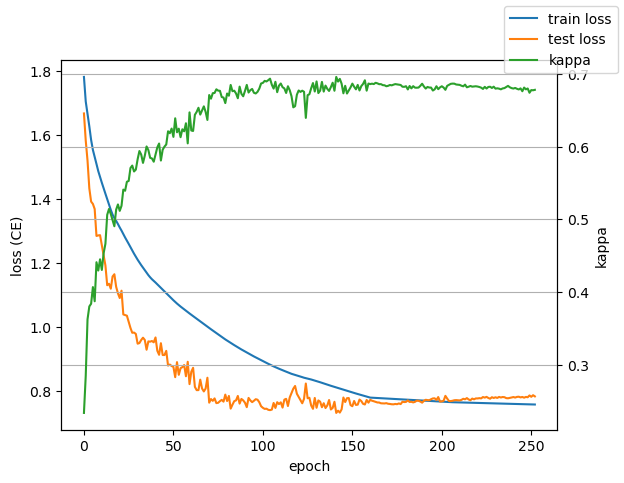

In [48]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))